# 1. Code for Classification with the QNN - part 2

In this version, the examples of training data are more varied than in the first one. In case one also aims for Subset Training or Training with noisy data as done there, some small changes are necessary. Attention must be paid to the slightly different creation of training data and the modificated function $\text{howmanywrong2}$ then.

## 1.1 Package-imports, universal definitions and remarks

Import the relevant packages:

In [1]:
#math related packages
import numpy as np
import scipy as sc
import qutip as qt
#further packages
from time import time
from random import sample
from random import choice
import matplotlib.pyplot as plt
import csv

Declaration of qubit kets and density matrices:

In [2]:
#ket states
qubit0 = qt.basis(2,0)
qubit1 = qt.basis(2,1)
#density matrices
qubit0mat = qubit0 * qubit0.dag()
qubit1mat = qubit1 * qubit1.dag()

Declaring functions for Dirac notation:

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

### Data conventions

The parameter QNN-Architecture $\text{qnnArch}$ describes the structure of a quantum neural network. It is expected to be a 1-dimensional list of natural numbers that which refer to the number of perceptrons in the corresponding layer. E.g. a 2-3-2 network would be given by $\text{qnnArch = [2, 3, 2]}$


Any parameter $\text{unitaries}$ is expected to be a 2-dimensional list of the networks perceptron unitaries (qutip.Qobj) given in a tensored state like

$$\text{unitaries}  = \big[ [\, ],[U_1^1, \dots, U_{m_1}^1], \dots, [U_1^l, \dots, U_{m_l}^l], \dots, [U_1^{out}, \dots, U_{m_{out}}^{out}]\big]$$

$$\text{unitaries[l][j]} = U_{j+1}^l$$

(The latter formula assumes that zero-indexing is not used for the perceptron unitaries, as is indicated in the former formula)


Any parameter $\text{trainingData}$ is expected to be a 2-dimensional list, where every inner list has exactly two elements like

$$trainingData = \big[ [\text{state}_1,\, \text{qubit0/1}], \dots , [\text{state}_N,\, \text{qubit0/1}] \big]$$

where $\text{unitary}$ is the targeted network unitary.

## 1.2 Helper functions for the QNN-Code

### Partial Trace

The $\text{partialTrace}$ functions assume to be given a quantum object (qutip.Qobj) $\text{obj}$ that is the tensor product of m factors $\{0, 1, \dots, m-1\}$. The functions then calculate and return the partial trace as follows:

$\text{partialTraceRem}$ traces out the factors $$\text{rem} \subsetneq \{0, \dots, m-1\}$$

$\text{partialTraceKeep}$ traces out the factors $$\big( \{0, \dots, m-1\} \setminus \text{keep}\big) \subsetneq \{0, \dots, m-1\}$$

No duplicates in $\text{rem}$ allowed. No values $\geq m$ in $\text{rem}$ or $\text{keep}$ allowed.

In [3]:
def partialTraceRem(obj, rem):
    #prepare keep list
    rem.sort(reverse=True)
    keep = list(range(len(obj.dims[0])))
    for x in rem:
        keep.pop(x)
    #return partial trace:
    res = obj.ptrace(keep)
    return res

def partialTraceKeep(obj, keep):
    #return partial trace:
    return obj.ptrace(keep)

### Basis swap

$\text{swappedOp}$ assumes to be given a quantum object (qutip.Qobj) $\text{obj}$ that is the tensor product of $m$ factors. For

$$\text{obj} = A_0 \otimes \dots \otimes A_i \otimes \dots \otimes A_j \otimes \dots A_{m-1}$$

the function returns

$$A_0 \otimes \dots \otimes A_j \otimes \dots \otimes A_i \otimes \dots A_{m-1}$$

where $i, j \in \{1, \dots, m \}$.

In [4]:
def swappedOp(obj, i, j):
    if i==j: return obj
    numberOfQubits = len(obj.dims[0])
    permute = list(range(numberOfQubits))
    permute[i], permute[j] = permute[j], permute[i]
    return obj.permute(permute)

### Further functions

$\text{tensoredId}$ returns $\underbrace{\mathbb{1}_2 \otimes \dots \otimes \mathbb{1}_2}_{N \text{-times}}$

$\text{tensoredQubit0}$ returns $\ket{0 \dots 0}_N \bra{0 \dots 0}$

In [5]:
def tensoredId(N):
    #Make Identity matrix
    res = qt.qeye(2**N)
    #Make dims list
    dims = [2 for i in range(N)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

def tensoredQubit0(N):
    #Make Qubit matrix
    res = qt.fock(2**N).proj() #For some reason ran faster than fock_dm(2**N) in tests
    #Make dims list
    dims = [2 for i in range(N)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

$\text{unitariesCopy}$ assumes to be given $\text{unitaries}$ as usual and returns a deep copy of it, meaning a new 2-dimensional list where every element is a copy of the element at the same position in the given 2d-list.

In [6]:
def unitariesCopy(unitaries):
    newUnitaries = []
    for layer in unitaries:
        newLayer = []
        for unitary in layer:
            newLayer.append(unitary.copy())
        newUnitaries.append(newLayer)
    return newUnitaries

## 1.3 Random generation of unitaries, training data and networks

### Generation of random unitaries:

$\text{randomQubitUnitary}$ return a unitary $2^{\text{numQubits}} \times 2^{\text{numQubits}}$-matrix as a quantum object (qutip.Qobj) that is the tensor product of $\text{numQubits}$ factors. Before orthogonalization, it's elements are randomly picked out of a normal distribution.

In [7]:
def randomQubitUnitary(numQubits):
    dim = 2**numQubits
    #Make unitary matrix
    res = sc.random.normal(size=(dim,dim)) + 1j * sc.random.normal(size=(dim,dim))
    res = sc.linalg.orth(res)
    res = qt.Qobj(res)
    #Make dims list
    dims = [2 for i in range(numQubits)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

### Bloch sphere

$\text{blochvec}$ maps an input state (as a density matrix) to a vector on the bloch sphere:

In [8]:
def blochvec(inputState):
     mat = 2 * sc.array(inputState)
     x = mat[0][1].real
     y = mat[1][0].imag
     z = mat[0][0].real - 1
     return [x,y,z]

### Generation of random training data

$\text{randomQubitState}$ return a unitary $2^{\text{numQubits}}$-vector as a quantum object (qutip.Qobj) that is the tensor product of $\text{numQubits}$ factors. Before normalization, it's elements are randomly picked out of a normal distribution.

$\text{randomTrainingData}$ returns a list of $N$ training pairs like

$$trainingData = \big[ [\text{state}_1,\, \text{qubit0/1}], \dots , [\text{state}_N,\, \text{qubit0/1}] \big]$$

To each input state, one of the basic states, qubit0 and qubit1, is assigned. They correspond to the labels 0 and 1. They are assigned by choosing a plane separating the sphere into two parts. Let $\mathbf{n}$ be the normal vector of the plane and $b$ the shift. If $\mathbf{n}\cdot\mathbf{x}+b>0$, the label is 0, otherwise 1.

In [9]:
def randomQubitState(numQubits):
    dim = 2**numQubits
    #Make normalized state
    res = sc.random.normal(size=(dim,1)) + 1j * sc.random.normal(size=(dim,1))
    res = (1/sc.linalg.norm(res)) * res
    res = qt.Qobj(res)
    #Make dims list
    dims1 = [2 for i in range(numQubits)]
    dims2 = [1 for i in range(numQubits)]
    dims = [dims1, dims2]
    res.dims = dims
    #Return
    return res

def randomTrainingData(N, nVector, b):
    #numQubits = len(unitary.dims[0])
    trainingData=[]
    #Create training data pairs
    for i in range(N):
        stateIn = randomQubitState(1)
        rho = stateIn * stateIn.dag()
        bloch = blochvec(rho)
        stateOut = qubit1
        if np.dot(nVector, bloch)+b>0:
            stateOut = qubit0
        trainingData.append([stateIn,stateOut])
    #Return
    return trainingData

#for random plane:
#nVector = np.random.rand(3)
#nVector = nVector / np.linalg.norm(nVector)
#b = np.random.uniform(-0.8,0.8)

### Note regarding Qobj.dims

Quantum objects $\text{Qobj}$ in the $\text{qutip}$ package have two properties regarding their sizes: $\text{shape}$ and $\text{dims}$. While $\text{shape}$ denotes the "dimensions of the underlying data matrix", $\text{dims}$ is a "list keeping track of shapes for individual components of a multipartite system" (quoted from the $\text{qutip}$-documentation). The qutip package will only allow operations such as the multiplication of two $\text{Qobj}$ objects $A$ and $B$, if not only their $\text{shape}$s, but also their $\text{dims}$ are compatible. Essentially all $\text{Qobj}$ objects in this work are representing operators or states in an multipartite system of $n$ qubits. As we create such objects with the desired $\text{shape}$, we have to ensure that their $\text{dims}$ are reflective of that, which is why we manually overwrite them to meet this criteria.

### Generation of an initial network

$\text{randomNetwork}$ will, given a valid $\text{qnnArch}$ as usual, return a 4-tuple that completely describes a trainable quantum-neural-network like

$$\big(\text{qnnArch}, \ \text{unitaries} , \ \text{trainingData}, \ \text{networkUnitary} \big)$$

With $\text{qnnArch},\, \text{unitaries}$ and $\text{trainingData}$ as usual and $\text{networkUnitary}$ being the targeted network unitary (with which the training data was created).

In [10]:
def randomNetwork(qnnArch, numTrainingPairs, nVector, b):
    assert qnnArch[0]==qnnArch[-1], "Not a valid QNN-Architecture."
    
    #Create the targeted network unitary and corresponding training data
    networkTrainingData = randomTrainingData(numTrainingPairs, nVector, b)
    
    #Create the initial random perceptron unitaries for the network
    networkUnitaries = [[]]
    for l in range(1, len(qnnArch)):
        numInputQubits = qnnArch[l-1]
        numOutputQubits = qnnArch[l]
        
        networkUnitaries.append([])
        for j in range(numOutputQubits):
            unitary = qt.tensor(randomQubitUnitary(numInputQubits+1), tensoredId(numOutputQubits-1))
            unitary = swappedOp(unitary, numInputQubits, numInputQubits + j)
            networkUnitaries[l].append(unitary)
    
    #Return
    return (qnnArch, networkUnitaries, networkTrainingData)

## 1.4 QNN-Code

### Cost Function

$\text{costFunction}$ assumes to be given $\text{trainingData}$ and $\text{outputStates}$ so that

$$\text{trainingData[x][1]} = \ket{\phi_x^{out}}$$

$$\text{outputStates[x]} = \rho_x^{out}(s)$$

and computes the cost function:

$$C(s) = \frac{1}{N} \sum_{x = 1}^N \bra{\phi_x^{out}} \rho_x^{out}(s) \ket{\phi_x^{out}}$$

In [11]:
def costFunction(trainingData, outputStates):
    costSum = 0
    for i in range(len(trainingData)):
        costSum += trainingData[i][1].dag() * outputStates[i] * trainingData[i][1]
    return costSum.tr()/len(trainingData)

### Layer-Channel & Adjoint-Layer-Channel

$\text{makeLayerChannel}$ assumes to be given $\text{qnnArch}$ and $\text{currentUnis}$ as usual and calculates

\begin{align}
\\
\mathcal{E}_s^l(X^{l-1}) & = \text{tr}_{l-1}\bigg( U^l(s) \ \big( X^{l-1} \otimes \ket{0 \dots 0}_l \bra{0 \dots 0} \big) \ U^l(s)^{\dagger} \bigg) \\
& = \text{tr}_{l-1}\bigg( U_{m_l}^l(s) \dots U_1^l(s) \ \big( X^{l-1} \otimes \ket{0 \dots 0}_l \bra{0 \dots 0} \big) \ U_1^l(s)^{\dagger} \dots U_{m_l}^l(s)^{\dagger} \bigg) 
\\
\end{align}

for $\text{inputState} = X^{l-1}$

In [12]:
def makeLayerChannel(qnnArch, unitaries, l, inputState):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    #Tensor input state
    state = qt.tensor(inputState, tensoredQubit0(numOutputQubits))

    #Calculate layer unitary
    layerUni = unitaries[l][0].copy()
    for i in range(1, numOutputQubits):
        layerUni = unitaries[l][i] * layerUni

    #Multiply and tensor out input state
    return partialTraceRem(layerUni * state * layerUni.dag(), list(range(numInputQubits)))

$\text{makeAdjointLayerChannel}$ assumes to be given $\text{qnnArch}$ and $\text{unitaries}$ as usual and calculates

\begin{align}
\\
\mathcal{F}_s^l(X^{l}) & = \text{tr}_{l}\bigg( \big( \mathbb{1}_{l-1} \otimes \ket{0 \dots 0}_l \bra{0 \dots 0} \big) \ U^{l}(s)^{\dagger} \ \big( \mathbb{1}_{l-1} \otimes X^l \big) \ U^l(s) \bigg) \\
& = \text{tr}_{l}\bigg( \big( \mathbb{1}_{l-1} \otimes \ket{0 \dots 0}_l \bra{0 \dots 0} \big) \ U_1^l(s)^{\dagger} \dots U_{m_l}^l(s)^{\dagger} \ \big( \mathbb{1}_{l-1} \otimes X^l \big) \ U_{m_l}^l(s) \dots U_1^l(s) \bigg)
\\
\end{align}


for $\text{inputState} = X^{l}$

In [13]:
def makeAdjointLayerChannel(qnnArch, unitaries, l, outputState):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]
    
    #Prepare needed states
    inputId = tensoredId(numInputQubits)
    state1 = qt.tensor(inputId, tensoredQubit0(numOutputQubits))
    state2 = qt.tensor(inputId, outputState)

    #Calculate layer unitary
    layerUni = unitaries[l][0].copy()
    for i in range(1, numOutputQubits):
        layerUni = unitaries[l][i] * layerUni
    
    #Multiply and tensor out output state
    return partialTraceKeep(state1 * layerUni.dag() * state2 * layerUni, list(range(numInputQubits)) )

### Feedforward

$\text{feedforward}$ assumes to be given $\text{qnnArch},\, \text{unitaries}$ and $\text{trainingData}$ as usual, carries out the feedforward process as described in Appendix D.2 of ***Efficient Learning for Deep Quantum Neural Networks***:

For each element $\big[\, \ket{\phi_x^{in}},\, \ket{\phi_x^{out}} \big]$ in $\text{trainingData}$ do:

- Calculate the network input $\rho_x^{in} = \ket{\phi_x^{in}} \bra{\phi_x^{in}}$

- For every layer $l$ in $\text{qnnArch}$ do:

    - Apply the layer channel $\mathcal{E}_s^l$ to the output of the previous layer $l-1$

    - Store the result $\rho_x^l(s)$

In [14]:
def feedforward(qnnArch, unitaries, trainingData):
    storedStates = []
    for x in range(len(trainingData)):
        currentState = trainingData[x][0] * trainingData[x][0].dag()
        layerwiseList = [currentState]
        for l in range(1, len(qnnArch)):
            currentState = makeLayerChannel(qnnArch, unitaries, l, currentState)
            layerwiseList.append(currentState)
        storedStates.append(layerwiseList)
    return storedStates

### Update matrix

$\text{makeUpdateMatrix}$ assumes to be given $\text{qnnArch},\, \text{unitaries},\, \text{trainingData}$ and $\text{storedStates}$ as usual, as well as $\lambda,\, \epsilon \in \mathbb{R}$, and calculates

$$\text{exp}\big( i \, \epsilon \, K_j^l(s) \big)$$

with

$$K_j^l(s) = \frac{2^{n_{a_1, \dots, \beta}} \, i}{2 N \lambda} \sum_x \text{tr}_\text{rest} M_j^l(s)$$

with 

$$M_j^l(s) = \big[A_j^l(s), B_j^l(s) \big]$$

with

\begin{align}
A_j^l(s) & = U_j^l(s) \dots U_1^l(s) \, \big( \rho_x^{l-1}(s) \otimes \ket{0 \dots 0}_l \bra{0 \dots 0} \big) \, U_1^l(s)^{\dagger} \dots U_j^l(s)^{\dagger} \\
\\
B_j^l(s) & = U_{j+1}^l(s)^{\dagger} \dots U_{m_l}^l(s)^{\dagger} \, \big( \mathbb{1}_l \otimes \sigma_x^l(s) \big) \, U_{m_l}^l(s) \dots U_{j+1}^l(s)
\end{align}

with

$$\sigma_x^l(s) = \mathcal{F}_s^{l+1} \big( \dots \mathcal{F}_s^{out} \big( \ket{\phi_x^{out}} \bra{\phi_x^{out}} \big) \dots \big)$$

$\text{updateMatrixFirstPart}$ calculates $A_j^l(s)$, $\text{updateMatrixSecondPart}$ calculates $B_j^l(s)$.

$\text{makeUpdateMatrixTensored}$ tensors the calculated as above update matrix in such a way, that it can be applied to the already tensored perceptron unitaries.

In [15]:
def makeUpdateMatrix(qnnArch, unitaries, trainingData, storedStates, lda, ep, l, j):
    numInputQubits = qnnArch[l-1]
    
    #Calculate the sum:
    summ = 0
    for x in range(len(trainingData)):
        #Calculate the commutator
        firstPart = updateMatrixFirstPart(qnnArch, unitaries, storedStates, l, j, x)
        secondPart = updateMatrixSecondPart(qnnArch, unitaries, trainingData, l, j, x)
        mat = qt.commutator(firstPart, secondPart)
        
        #Trace out the rest
        keep = list(range(numInputQubits))
        keep.append(numInputQubits + j)
        mat = partialTraceKeep(mat, keep)
        
        #Add to sum
        summ = summ + mat

    #Calculate the update matrix from the sum
    summ = (-ep * (2**numInputQubits)/(lda*len(trainingData))) * summ
    return summ.expm()


def updateMatrixFirstPart(qnnArch, unitaries, storedStates, l, j, x):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]
    
    #Tensor input state
    state = qt.tensor(storedStates[x][l-1], tensoredQubit0(numOutputQubits))
    
    #Calculate needed product unitary
    productUni = unitaries[l][0]
    for i in range(1, j+1):
        productUni = unitaries[l][i] * productUni
    
    #Multiply
    return productUni * state * productUni.dag()


def updateMatrixSecondPart(qnnArch, unitaries, trainingData, l, j, x):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]
    
    #Calculate sigma state
    state = trainingData[x][1] * trainingData[x][1].dag()
    for i in range(len(qnnArch)-1,l,-1):
        state = makeAdjointLayerChannel(qnnArch, unitaries, i, state)
    #Tensor sigma state
    state = qt.tensor(tensoredId(numInputQubits), state)
    
    #Calculate needed product unitary
    productUni = tensoredId(numInputQubits + numOutputQubits)
    for i in range(j+1, numOutputQubits):
        productUni = unitaries[l][i] * productUni
        
    #Multiply
    return productUni.dag() * state * productUni


def makeUpdateMatrixTensored(qnnArch, unitaries, lda, ep, trainingData, storedStates, l, j):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]
    
    res = qt.tensor(makeUpdateMatrix(qnnArch, unitaries, lda, ep, trainingData, storedStates, l, j), tensoredId(numOutputQubits-1))
    
    return swappedOp(res, numInputQubits, numInputQubits + j)

### Training of the Quantum Neural Network

$\text{qnnTraining}$ assumes to be given $\text{qnnArch},\, \text{initialUnitaries}$ and $\text{trainingData}$ as usual, as well as $\lambda,\, \epsilon \in \mathbb{R}$ and $\text{trainingRounds} \in \mathbb{N}$, and trains the given quantum neural network as summarized in Figure 2 of ***Efficient Learning for Deep Quantum Neural Networks***:

**Step 1: Feedforward:** For every training pair, for every layer: Apply the layer channel $\mathcal{E}^l$ and store the result

**Step 2: Updating:** Update every unitary in every layer according to $U^l_j \rightarrow e^{i \, \epsilon \, K^l_j} \ U^l_j$

**Termination: Repeat Steps 1 and 2 $\text{trainingRounds}$ times**

In [16]:
def qnnTraining(qnnArch, initialUnitaries, trainingData, lda, ep, trainingRounds, alert=0):
    
    ### FEEDFORWARD    
    #Feedforward for given unitaries
    s = 0
    currentUnitaries = initialUnitaries
    storedStates = feedforward(qnnArch, currentUnitaries, trainingData)

    #Cost calculation for given unitaries
    outputStates = []
    for k in range(len(storedStates)):
        outputStates.append(storedStates[k][-1])
    plotlist = [[s], [costFunction(trainingData, outputStates)]]
    
    #Optional
    runtime = time()
    
    #Training of the Quantum Neural Network
    for k in range(trainingRounds):
        if alert>0 and k%alert==0: print("In training round "+str(k))
        
        ### UPDATING
        newUnitaries = unitariesCopy(currentUnitaries)
        
        #Loop over layers:
        for l in range(1, len(qnnArch)):
            numInputQubits = qnnArch[l-1]
            numOutputQubits = qnnArch[l]
            
            #Loop over perceptrons
            for j in range(numOutputQubits):
                newUnitaries[l][j] = (makeUpdateMatrixTensored(qnnArch,currentUnitaries,trainingData,storedStates,lda,ep,l,j)* currentUnitaries[l][j])
        
        ### FEEDFORWARD
        #Feedforward for given unitaries
        s = s + ep
        currentUnitaries = newUnitaries
        storedStates = feedforward(qnnArch, currentUnitaries, trainingData)
        
        #Cost calculation for given unitaries
        outputStates = []
        for m in range(len(storedStates)):
            outputStates.append(storedStates[m][-1])
        plotlist[0].append(s)
        plotlist[1].append(costFunction(trainingData, outputStates))
    
    #Optional
    runtime = time() - runtime
    print("Trained "+str(trainingRounds)+" rounds for a "+str(qnnArch)+" network and "+str(len(trainingData))+" training pairs in "+str(round(runtime, 2))+" seconds")
    
    #Return
    return [plotlist, currentUnitaries]

## 1.5 Classification after training

The following function simulates R mesurements for each state. The outcome of each measurement is either +1 (respectively 0) or -1 (respectively 1) (+1  corresponds to qubit0, -1 to qubit1). The function returns a list with the empirical probabilities for all states.

In [17]:
def measurements(qnnArch, unitaries, trainingData, R):
    feed = feedforward(qnnArch, unitaries, trainingData)
    prob = []
    for i in range(len(trainingData)):
        state = feed[i][-1]
        a = [] # probabilities with tr(E_i*rho)
        a.append(np.trace(np.array(qubit0mat*state)).real)
        a.append(np.trace(np.array(qubit1mat*state)).real)
        results = np.random.choice([1,-1], R, p=a)
        #number of measurements with outcome +1:
        k = 0
        for i in range(R):
            if results[i] == 1:
                k = k+1
        #empirical probability distribution:
        plus = k/R
        minus = (R - k)/R
        prob.append([plus, minus])
    return prob

$\text{howManyWrong}$ returns the fraction of wrong classifications, where the classification protocol is tested for the training data. $R$ measurements are performed on the output states. This should only be uses if it is known that $b=0$. In this case, a classification is wrong if the empirical probability for the correct label is less than 0.5.

In [18]:
def howManyWrong(qnnArch, unitaries, trainingData, R):
    prob = measurements(qnnArch, unitaries, trainingData, R)
    m = len(trainingData)
    x = 0
    for i in range(m):
        if trainingData[i][1] == qubit0:
            if prob[i][0] < 0.5:
                x = x + 1
        else:
            if prob[i][1] < 0.5:
                x = x + 1
    x = x/m
    return x

$\text{howManyWrong2}$ returns the fraction of wrong classifications independently from $b$. For this, we calculate the value $c$. This is a threshold for the empirical probabilities with a value from 0 to 1. The assigned label is 0 if the empirical probability for the label 0 is greater than $c$, the label is 1 if the empirical probability for the label 1 is greater than $1-c$. By this, we can determine how many states are falsely classified. Ideally, it is $c=(1-b)/2$.

To find $c$, the empirical probability to obtain label 0 is observed. We find its minimum for labels with label 0 and its maximum for states with label 1. $c$ is determined to be the average of these two values.

In [19]:
def howManyWrong2(qnnArch, unitaries, trainingData, R):
    prob = measurements(qnnArch, unitaries, trainingData, R)
    m = len(trainingData)
    high = 1
    low = 0
    x = 0
    for i in range(m):
        if trainingData[i][1] == qubit0:
            if prob[i][0]<high:
                high = prob[i][0]
        else:
            if prob[i][0]>low:
                low = prob[i][0]
    c = (high + low) / 2
    bCalculated = 1 - 2*c
    for i in range(m):
        if trainingData[i][1] == qubit0:
            if prob[i][0] < c:
                x = x + 1
        else:
            if prob[i][1] < 1 - c:
                x = x + 1
    x = x/m
    return [x, c, bCalculated]

## 1.6 Export to csv

From the data in form of a list $[[\dots],[\dots]]$ (for example for the plots), a csv file is created. The list needs to be transposed for this. The name of the file has the form 'file.csv'.

In [20]:
def exporttocsv(name, data):
    with open(name, 'w', newline='') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        filewriter.writerow(['a','b'])
        filewriter.writerows(list(map(list, zip(*data))))

# 2. Tests and Applications of the QNN-Code

## 2.1 Elementary tests

### Training a 1-3-1 network

Trained 200 rounds for a [1, 3, 1] network and 50 training pairs in 112.54 seconds
Exceeds cost of 0.75 at training step 51


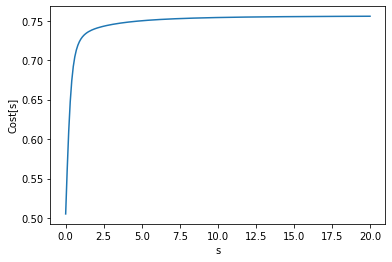

In [20]:
network131 = randomNetwork([1,3,1], 50, [0,0,1], 0)
plotlist131, unitaries131 = qnnTraining(network131[0], network131[1], network131[2], 1, 0.1, 200)

for i in range(len(plotlist131[1])):
    if plotlist131[1][i] >= 0.75:
        print("Exceeds cost of 0.75 at training step "+str(i))
        break

plt.plot(plotlist131[0], plotlist131[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

In [21]:
#exporttocsv('classif131.csv',plotlist131)

In [22]:
print(howManyWrong(network131[0], unitaries131, network131[2], 1))
print(howManyWrong(network131[0], unitaries131, network131[2], 10))
print(howManyWrong(network131[0], unitaries131, network131[2], 1000))
print(howManyWrong2(network131[0], unitaries131, network131[2], 1))
print(howManyWrong2(network131[0], unitaries131, network131[2], 10))
print(howManyWrong2(network131[0], unitaries131, network131[2], 1000))

0.2
0.02
0.02
[0.26, 0.5, 0.0]
[0.06, 0.5, 0.0]
[0.0, 0.456, 0.08799999999999997]


### Training a 1-1 network

Trained 400 rounds for a [1, 1] network and 50 training pairs in 45.29 seconds


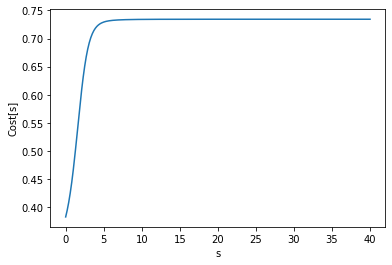

In [23]:
network11 = randomNetwork([1,1], 50, [0,0,1], 0)
plotlist11, unitaries11 = qnnTraining(network11[0], network11[1], network11[2], 1, 0.1, 400)

for i in range(len(plotlist11[1])):
    if plotlist11[1][i] >= 0.75:
        print("Exceeds cost of 0.75 at training step "+str(i))
        break

plt.plot(plotlist11[0], plotlist11[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

In [24]:
#exporttocsv('classif11.csv',plotlist11)

In [25]:
print(howManyWrong(network11[0], unitaries11, network11[2], 1))
print(howManyWrong(network11[0], unitaries11, network11[2], 10))
print(howManyWrong(network11[0], unitaries11, network11[2], 1000))
print(howManyWrong2(network11[0], unitaries11, network11[2], 1))
print(howManyWrong2(network11[0], unitaries11, network11[2], 10))
print(howManyWrong2(network11[0], unitaries11, network11[2], 1000))

0.18
0.08
0.04
[0.24, 0.5, 0.0]
[0.26, 0.55, -0.10000000000000009]
[0.04, 0.47750000000000004, 0.04499999999999993]


### Training a 1-1-1 network

Trained 400 rounds for a [1, 1, 1] network and 50 training pairs in 96.39 seconds


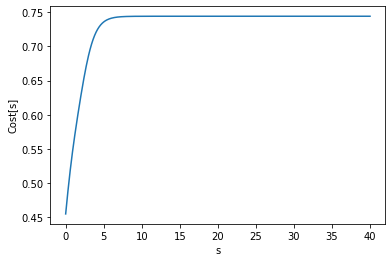

In [26]:
nVector111 = np.random.rand(3)
nVector111 = nVector111 / np.linalg.norm(nVector111)
network111 = randomNetwork([1,1,1], 50, nVector111, 0)
plotlist111, unitaries111 = qnnTraining(network111[0], network111[1], network111[2], 1, 0.1, 400)

for i in range(len(plotlist111[1])):
    if plotlist111[1][i] >= 0.75:
        print("Exceeds cost of 0.75 at training step "+str(i))
        break

plt.plot(plotlist111[0], plotlist111[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

In [27]:
#exporttocsv('classif111.csv',plotlist111)

In [28]:
print(howManyWrong(network111[0], unitaries111, network111[2], 1))
print(howManyWrong(network111[0], unitaries111, network111[2], 10))
print(howManyWrong(network111[0], unitaries111, network111[2], 1000))
print(howManyWrong2(network111[0], unitaries111, network111[2], 1))
print(howManyWrong2(network111[0], unitaries111, network111[2], 10))
print(howManyWrong2(network111[0], unitaries111, network111[2], 1000))

0.24
0.1
0.02
[0.28, 0.5, 0.0]
[0.12, 0.55, -0.10000000000000009]
[0.04, 0.5335000000000001, -0.06700000000000017]


### Training a 1-5-1 network

0.4049350439926649
Trained 200 rounds for a [1, 5, 1] network and 50 training pairs in 252.91 seconds
Exceeds cost of 0.75 at training step 9


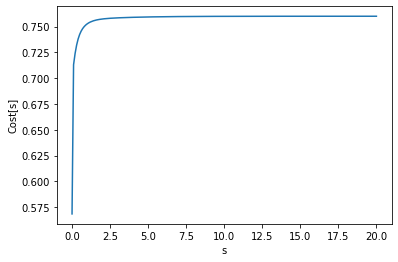

In [29]:
nVector151 = np.random.rand(3)
nVector151 = nVector151 / np.linalg.norm(nVector151)
b151 = np.random.uniform(-0.5,0.5)
print(b151)
network151 = randomNetwork([1,5,1], 50, nVector151, b151)
plotlist151, unitaries151 = qnnTraining(network151[0], network151[1], network151[2], 1, 0.1, 200)

for i in range(len(plotlist151[1])):
    if plotlist151[1][i] >= 0.75:
        print("Exceeds cost of 0.75 at training step "+str(i))
        break

plt.plot(plotlist151[0], plotlist151[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

In [30]:
#exporttocsv('classif151.csv',plotlist151)

In [31]:
print(howManyWrong2(network151[0], unitaries151, network151[2], 1))
print(howManyWrong2(network151[0], unitaries151, network151[2], 10))
print(howManyWrong2(network151[0], unitaries151, network151[2], 1000))

[0.0, 1.0, -1.0]
[0.0, 1.0, -1.0]
[0.26, 0.9995, -0.9990000000000001]


### Training a 1-3-3-1 network

Trained 200 rounds for a [1, 3, 3, 1] network and 50 training pairs in 263.74 seconds
Exceeds cost of 0.75 at training step 41


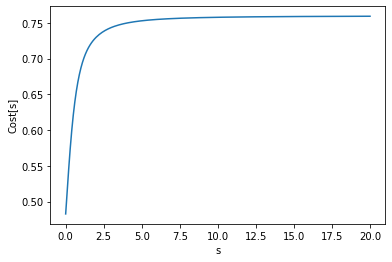

In [32]:
nVector1331 = np.random.rand(3)
nVector1331 = nVector1331 / np.linalg.norm(nVector1331)
network1331 = randomNetwork([1,3,3,1], 50, nVector1331, 0.3)
plotlist1331, unitaries1331 = qnnTraining(network1331[0], network1331[1], network1331[2], 1, 0.1, 200)

for i in range(len(plotlist1331[1])):
    if plotlist1331[1][i] >= 0.75:
        print("Exceeds cost of 0.75 at training step "+str(i))
        break

plt.plot(plotlist1331[0], plotlist1331[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

In [33]:
#exporttocsv('classif1331.csv',plotlist1331)

In [34]:
print(howManyWrong2(network1331[0], unitaries1331, network1331[2], 1))
print(howManyWrong2(network1331[0], unitaries1331, network1331[2], 10))
print(howManyWrong2(network1331[0], unitaries1331, network1331[2], 1000))

[0.0, 1.0, -1.0]
[0.22, 0.95, -0.8999999999999999]
[0.32, 0.9964999999999999, -0.9929999999999999]


## 2.2 Ablility for classification

### Test of several architectures and values of $R$

In the following, training and classification are done twelve times for each of the previously used five architectures. The list $\text{errordata}$ contains the fraction of wrong classifications for each training. We use $R=1$ and $R=1000$.

In [35]:
errordata = [[], [], [], [], [], [], [], [], [], []]
for i in range(12):
    network11 = randomNetwork([1,1], 50, [0,1,0], 0.2)
    plotlist11, unitaries11 = qnnTraining(network11[0], network11[1], network11[2], 1, 0.1, 400)
    error1 = howManyWrong2(network11[0], unitaries11, network11[2], 1)[0]
    errordata[0].append(error1)
    error1000 = howManyWrong2(network11[0], unitaries11, network11[2], 1000)[0]
    errordata[1].append(error1000)
    
    network111 = randomNetwork([1,1,1], 50, [0,1,0], 0.2)
    plotlist111, unitaries111 = qnnTraining(network111[0], network111[1], network111[2], 1, 0.1, 400)
    error1 = howManyWrong2(network111[0], unitaries111, network111[2], 1)[0]
    errordata[2].append(error1)
    error1000 = howManyWrong2(network111[0], unitaries111, network111[2], 1000)[0]
    errordata[3].append(error1000)
    
    network131 = randomNetwork([1,3,1], 50, [0,1,0], 0.2)
    plotlist131, unitaries131 = qnnTraining(network131[0], network131[1], network131[2], 1, 0.1, 200)
    error1 = howManyWrong2(network131[0], unitaries131, network131[2], 1)[0]
    errordata[4].append(error1)
    error1000 = howManyWrong2(network131[0], unitaries131, network131[2], 1000)[0]
    errordata[5].append(error1000)
    
    network151 = randomNetwork([1,5,1], 50, [0,1,0], 0.2)
    plotlist151, unitaries151 = qnnTraining(network151[0], network151[1], network151[2], 1, 0.1, 100)
    error1 = howManyWrong2(network151[0], unitaries151, network151[2], 1)[0]
    errordata[6].append(error1)
    error1000 = howManyWrong2(network151[0], unitaries151, network151[2], 1000)[0]
    errordata[7].append(error1000)
    
    network1331 = randomNetwork([1,3,3,1], 50, [0,1,0], 0.2)
    plotlist1331, unitaries1331 = qnnTraining(network1331[0], network1331[1], network1331[2], 1, 0.1, 200)
    error1 = howManyWrong2(network1331[0], unitaries1331, network1331[2], 1)[0]
    errordata[8].append(error1)
    error1000 = howManyWrong2(network1331[0], unitaries1331, network1331[2], 1000)[0]
    errordata[9].append(error1000)

print(errordata)

Trained 400 rounds for a [1, 1] network and 50 training pairs in 47.04 seconds
Trained 400 rounds for a [1, 1, 1] network and 50 training pairs in 95.99 seconds
Trained 200 rounds for a [1, 3, 1] network and 50 training pairs in 94.85 seconds
Trained 100 rounds for a [1, 5, 1] network and 50 training pairs in 126.74 seconds
Trained 200 rounds for a [1, 3, 3, 1] network and 50 training pairs in 248.61 seconds
Trained 400 rounds for a [1, 1] network and 50 training pairs in 44.2 seconds
Trained 400 rounds for a [1, 1, 1] network and 50 training pairs in 94.04 seconds
Trained 200 rounds for a [1, 3, 1] network and 50 training pairs in 96.42 seconds
Trained 100 rounds for a [1, 5, 1] network and 50 training pairs in 128.43 seconds
Trained 200 rounds for a [1, 3, 3, 1] network and 50 training pairs in 249.4 seconds
Trained 400 rounds for a [1, 1] network and 50 training pairs in 44.57 seconds
Trained 400 rounds for a [1, 1, 1] network and 50 training pairs in 93.84 seconds
Trained 200 round

Create a csv file. Attention: for the first line better no commas like in '11,1'.

In [36]:
with open('errordataNew.csv', 'w', newline='') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(['11,1','11,1000','111,1','111,1000','131,1','131,1000','151,1','151,1000','1331,1','1331,1000'])
    filewriter.writerows(list(map(list, zip(*errordata))))

Compute the mean $\frac{1}{N}\sum\epsilon_{i}$ and the standard deviation $\sqrt{\frac{1}{N-1}\sum(\epsilon_{i}-\bar{\epsilon})^2}$ for each architecture:

In [37]:
meanAndStd = []
for i in range(10):
    meanAndStd.append([np.mean(errordata[i]), np.std(errordata[i], ddof=1)])
print(meanAndStd)

[[0.26833333333333337, 0.06117535649609442], [0.055000000000000014, 0.024308621740219888], [0.2783333333333333, 0.08881373085215365], [0.05000000000000001, 0.04134115273055299], [0.24500000000000002, 0.050542511359700504], [0.04833333333333334, 0.0404145188432738], [0.24166666666666667, 0.08375650133065203], [0.05333333333333334, 0.043762444117662294], [0.24000000000000007, 0.06980492298346351], [0.05499999999999999, 0.05125692857821982]]


### Test of the effect of $b$

In the following, training and classification are done twelve times each for several values for $b$. We get the rate of wrong classifications and the calculated value for $b$, which we can compare with the actual one.

In [39]:
datalist = []
for b in [0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    errors = []
    bValues = []
    for i in range(12):
        nVector11 = np.random.rand(3)
        nVector11 = nVector11 / np.linalg.norm(nVector11)
        network11 = randomNetwork([1,1], 50, nVector11, b)
        plotlist11, unitaries11 = qnnTraining(network11[0], network11[1], network11[2], 1, 0.1, 400)
        error11, c11, b11 = howManyWrong2(network11[0], unitaries11, network11[2], 1000)
        errors.append(error11)
        bValues.append(round(b11,3))
    datalist.append(errors)
    datalist.append(bValues)

print(datalist)

Trained 400 rounds for a [1, 1] network and 50 training pairs in 46.11 seconds
Trained 400 rounds for a [1, 1] network and 50 training pairs in 46.34 seconds
Trained 400 rounds for a [1, 1] network and 50 training pairs in 48.04 seconds
Trained 400 rounds for a [1, 1] network and 50 training pairs in 49.33 seconds
Trained 400 rounds for a [1, 1] network and 50 training pairs in 46.16 seconds
Trained 400 rounds for a [1, 1] network and 50 training pairs in 45.93 seconds
Trained 400 rounds for a [1, 1] network and 50 training pairs in 48.66 seconds
Trained 400 rounds for a [1, 1] network and 50 training pairs in 48.81 seconds
Trained 400 rounds for a [1, 1] network and 50 training pairs in 46.83 seconds
Trained 400 rounds for a [1, 1] network and 50 training pairs in 50.18 seconds
Trained 400 rounds for a [1, 1] network and 50 training pairs in 47.14 seconds
Trained 400 rounds for a [1, 1] network and 50 training pairs in 47.02 seconds
Trained 400 rounds for a [1, 1] network and 50 train

Create a csv file:

In [42]:
with open('datalist.csv', 'w', newline='') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(['er0','b0','er0.1','b0.1','er0.2','b0.2','er0.3','b0.3','er0.4','b0.4','er0.5','b0.5'])
    filewriter.writerows(list(map(list, zip(*datalist))))

Compute the mean $\frac{1}{N}\sum\epsilon_{i}$ and the standard deviation $\sqrt{\frac{1}{N-1}\sum(\epsilon_{i}-\bar{\epsilon})^2}$ for each architecture:

In [44]:
meanAndStd = []
for i in range(12):
    meanAndStd.append([round(np.mean(datalist[i]),4), round(np.std(datalist[i], ddof=1),4)])
print(meanAndStd)

[[0.0533, 0.0403], [0.036, 0.0574], [0.0417, 0.0289], [0.1083, 0.0824], [0.0317, 0.0262], [0.1912, 0.0548], [0.0533, 0.0841], [0.021, 0.5284], [0.0583, 0.069], [0.0023, 0.6018], [0.0233, 0.0317], [-0.3018, 0.7501]]


### Limit of the algorithm

If the plane is shifted to far, the diagonal elements of the output states will all be 0 and 1. This 
results in a wrong value for $c$ as all empirical probabilities are 0 and 1. Moreover, it is indicated that no state is falsely classified, which cannot be correct.

In [21]:
network11 = randomNetwork([1,1], 50, [0,0,1], 0.7)
plotlist11, unitaries11 = qnnTraining(network11[0], network11[1], network11[2], 1, 0.1, 400)
print(howManyWrong2(network11[0], unitaries11, network11[2], 1000))
print(measurements(network11[0], unitaries11, network11[2], 1000))
print(feedforward(network11[0], unitaries11, network11[2]))

network11 = randomNetwork([1,1], 50, [0,0,1], -0.7)
plotlist11, unitaries11 = qnnTraining(network11[0], network11[1], network11[2], 1, 0.1, 400)
print(howManyWrong2(network11[0], unitaries11, network11[2], 1000))
print(measurements(network11[0], unitaries11, network11[2], 1000))
print(feedforward(network11[0], unitaries11, network11[2]))

Trained 400 rounds for a [1, 1] network and 50 training pairs in 50.74 seconds
[0.0, 1.0, -1.0]
[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]
[[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.7141577 +0.j         0.10757704-0.43882076j]
 [0.10757704+0.43882076j 0.2858423 +0.j        ]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.00000000e+00+0.0

Trained 400 rounds for a [1, 1] network and 50 training pairs in 48.63 seconds
[0.0, 0.0, 1.0]
[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]
[[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.62455775+0.j       -0.48171306-0.049375j]
 [-0.48171306+0.049375j  0.37544225+0.j      ]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.00000000e+00+0.000000